In [ ]:
!pip install timm torch torchvision scikit-learn tqdm


In [ ]:
# ======================================================
# Step 1: Setup (Mount Drive, Install packages)
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision timm scikit-learn tqdm

# ======================================================
# Step 2: Unzip your dataset into /content/
# ======================================================
!rm -rf /content/DATA
!unzip -oq "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"

# Check dataset structure
!ls /content/DATA
!ls /content/DATA/train

Mounted at /content/drive
test  train  val
 acne   Eczema	 Psoriasis  'Tinea Ringworm'


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 198MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/40 - Train Acc: 0.5325 | Val Acc: 0.6247
Epoch 2/40 - Train Acc: 0.6395 | Val Acc: 0.6684
Epoch 3/40 - Train Acc: 0.7025 | Val Acc: 0.7099
Epoch 4/40 - Train Acc: 0.7403 | Val Acc: 0.7252
Epoch 5/40 - Train Acc: 0.7709 | Val Acc: 0.7556
Epoch 6/40 - Train Acc: 0.8059 | Val Acc: 0.7728
Epoch 7/40 - Train Acc: 0.8306 | Val Acc: 0.7779
Epoch 8/40 - Train Acc: 0.8473 | Val Acc: 0.8093
Epoch 9/40 - Train Acc: 0.8647 | Val Acc: 0.8053
Epoch 10/40 - Train Acc: 0.8769 | Val Acc: 0.7982
Epoch 11/40 - Train Acc: 0.8936 | Val Acc: 0.8164
Epoch 12/40 - Train Acc: 0.8984 | Val Acc: 0.8185
Epoch 13/40 - Train Acc: 0.9075 | Val Acc: 0.8195
Epoch 14/40 - Train Acc: 0.9183 | Val Acc: 0.8205
Epoch 15/40 - Train Acc: 0.9253 | Val Acc: 0.8164
Epoch 16/40 - Train Acc: 0.9292 | Val Acc: 0.8154
Epoch 17/40 - Train Acc: 0.9375 | Val Acc: 0.8215
Epoch 18/40 - Train Acc: 0.9477 | Val Acc: 0.8408
Epoch 19/40 - Train Acc: 0.9507 | Val Acc: 0.8357
Epoch 20/40 - Train Acc: 0.9514 | Val Acc: 0.8387
Epoch 21/

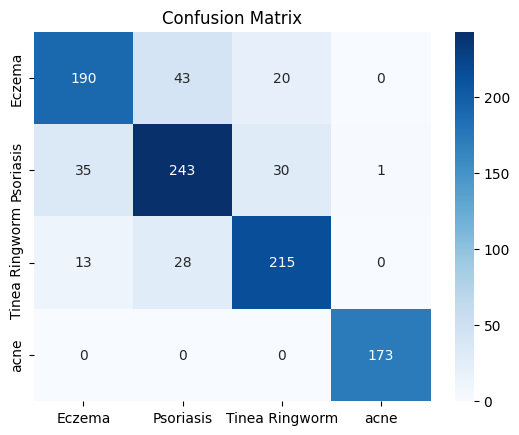

In [ ]:
# ======================================================
# Hybrid Custom Model for Skin Disease Classification
# ======================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/content/DATA"
batch_size = 16
num_epochs = 40
lr = 1e-4

# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomRotation(20),
    transforms.RandomAffine(15, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), transform=train_transforms)
val_ds = datasets.ImageFolder(os.path.join(data_dir,"val"), transform=test_transforms)
test_ds = datasets.ImageFolder(os.path.join(data_dir,"test"), transform=test_transforms)
class_names = train_ds.classes

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# ======================================================
# Custom Hybrid Model
# ======================================================
class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes):
        super(CNNTransformerHybrid, self).__init__()
        self.backbone = models.efficientnet_b3(pretrained=True).features
        self.conv_reduce = nn.Conv2d(1536, 512, kernel_size=1)

        # Lightweight transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_reduce(x)
        b, c, h, w = x.shape
        x = x.flatten(2).permute(2,0,1)  # (HW, B, C)
        x = self.transformer(x)
        x = x.mean(dim=0)
        out = self.fc(x)
        return out

# ======================================================
# Training setup
# ======================================================
model = CNNTransformerHybrid(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ======================================================
# Train loop
# ======================================================
def train_model(model, train_loader, val_loader):
    best_acc = 0.0
    history = {"train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        total, correct, loss_sum = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            loss_sum += loss.item()

        train_acc = correct / total
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                _, preds = torch.max(out, 1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_acc = val_correct / val_total
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/best_hybrid_model.pth")

    return history

# Train
history = train_model(model, train_loader, val_loader)

# ======================================================
# Evaluate
# ======================================================
model.load_state_dict(torch.load("/content/best_hybrid_model.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        _, preds = torch.max(out, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()
